## **Logistic Regression and Feature Engineering**

### **Description of the Dataset**

We will work with the Indian Liver Patient Dataset (ILPD) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/), performing feature engineering, data preprocessing, dimensionality reduction, and logistic regression to predict whether a patient has liver disease.

* The ILPD comprises 583 patient records with 10 biochemical/demographic features and a target feature that are listed below:

The dataset has the following columns:

- `Age` (Integer): Patient's age.
- `Gender` (Categorical: Male/Female).
- `TB` (Total Bilirubin, Continuous).
- `DB` (Direct Bilirubin, Continuous).
- `Alkphos` (Alkaline Phosphotase, Integer).
- `Sgpt` (Alamine Aminotransferase, Integer).
- `Sgot` (Aspartate Aminotransferase, Integer).
- `TP` (Total Proteins, Continuous).
- `ALB` (Albumin, Continuous).
- `A/G Ratio` (Albumin and Globulin Ratio, Continuous).
- `Selector` (Binary: 1 = Liver patient, 2 = Non-liver patient)

### **Load the Dataset**

In [61]:
import pandas as pd

# Download data
df = pd.read_csv('files/ILPD.csv', index_col=False)

# Define column names and cerate a dataframe
cols = ['age', 'gender', 'TB', 'DB', 'alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'A/G ratio', 'target']
df.columns = cols

# Convert 'Target' to binary classification (1 = Liver Patient, 0 = Non-Liver Patient)
df.loc[df['target'] == 2, 'target'] = 0

# display the first few row to observe the data
df.head()

,age,gender,TB,DB,alkphos,sgpt,sgot,TP,ALB,A/G ratio,target
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


### **Clean and transform the data**

Impute missing data

In [62]:
import numpy as np
from sklearn.impute import SimpleImputer

# Create new dataframe
df_imputed = df.copy()

# Select numeric columns
num_cols = df_imputed.select_dtypes(include=[np.number]).columns

# Impute null numeric values (if any) with median
if df_imputed[num_cols].isnull().values.any():
  imputer = SimpleImputer(strategy='median')           # Initialize imputer (median)
  df_imputed[num_cols] = imputer.fit_transform(df_imputed[num_cols])   # Fill missing values
  assert not df_imputed[num_cols].isnull().values.any(), 'Null numeric values found'  # Raise error if still missing values

# Select categorical columns
cat_cols = df_imputed.select_dtypes(exclude=[np.number]).columns

# Impute null categorical values (if any) with mode
if df_imputed[cat_cols].isnull().values.any:
  imputer = SimpleImputer(strategy='most_frequent')    # Initialize imputer (mode)
  df_imputed[cat_cols] = imputer.fit_transform(df_imputed[cat_cols])   # Fill missing values
  assert not df_imputed[cat_cols].isnull().values.any(), 'Null categorical values found' # Raise error if still missing values

One-hot Encoding: convert "Gender" into a binary feature (0 = Female, 1 = Male)

In [63]:
# Create new df
df_encoded = df_imputed.copy()

# Use vectorized operations, setting 'Male' == True
df_encoded['gender'] = (df_encoded['gender'] == 'Male').astype(int)
df_encoded.head()

,age,gender,TB,DB,alkphos,sgpt,sgot,TP,ALB,A/G ratio,target
0,62.0,1,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0
1,62.0,1,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0
2,58.0,1,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1.0
3,72.0,1,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1.0
4,46.0,1,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,1.0


### **Feature Extraction**

Engineer new features:
  - Bilirubin Ratio (DB / TB).
  - ALT/AST Ratio (Sgpt / Sgot).

In [64]:
# Create new engineered features
df_encoded['bilirubin ratio'] = df_encoded['DB'] / df_encoded['TB']
df_encoded['ALT/AST ratio'] = df_encoded['sgpt'] / df_encoded['sgot']
df_encoded.head(6)

,age,gender,TB,DB,alkphos,sgpt,sgot,TP,ALB,A/G ratio,target,bilirubin ratio,ALT/AST ratio
0,62.0,1,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0,0.504587,0.640000
1,62.0,1,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0,0.561644,0.882353
2,58.0,1,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1.0,0.400000,0.700000
3,72.0,1,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1.0,0.512821,0.457627
4,46.0,1,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,1.0,0.388889,1.357143
5,26.0,0,0.9,0.2,154.0,16.0,12.0,7.0,3.5,1.00,1.0,0.222222,1.333333


### **Standardization**

Scale all numerical features to have mean = 0 and standard deviation = 1.


In [65]:
from sklearn.preprocessing import StandardScaler

# Create new df
df_standard = df_encoded.copy()

# Select numerical columns (excluding categorical and target variable)
scale_cols = ['age', 'TB', 'DB', 'alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'A/G ratio', 'bilirubin ratio', 'ALT/AST ratio']

# Initialize and fit standard scaler
scaler = StandardScaler()
df_standard[scale_cols] = scaler.fit_transform(df_standard[scale_cols])

# Display first few rows after scaling
df_standard.head(6)

,age,gender,TB,DB,alkphos,sgpt,sgot,TP,ALB,A/G ratio,target,bilirubin ratio,ALT/AST ratio
0,1.069313,1,1.223586,1.428648,1.680715,-0.092140,-0.034853,0.937332,0.073438,-0.650251,1.0,0.463941,-0.472172
1,1.069313,1,0.643743,0.930056,0.820279,-0.114045,-0.145620,0.476661,0.199146,-0.179274,1.0,0.656711,-0.093879
2,0.821911,1,-0.370981,-0.387651,-0.447733,-0.365961,-0.311772,0.292392,0.324855,0.166110,1.0,0.110585,-0.378517
3,1.687818,1,0.096115,0.182168,-0.394213,-0.294768,-0.176774,0.753063,-0.932229,-1.717800,1.0,0.491758,-0.756841
4,0.079704,1,-0.242127,-0.280810,-0.340693,-0.338579,-0.332540,1.029466,1.581939,1.108065,1.0,0.073045,0.647230
5,-1.157306,0,-0.387087,-0.458878,-0.563007,-0.355008,-0.339463,0.476661,0.450563,0.166110,1.0,-0.490052,0.610065


### **Remove Highly Correlated Features**

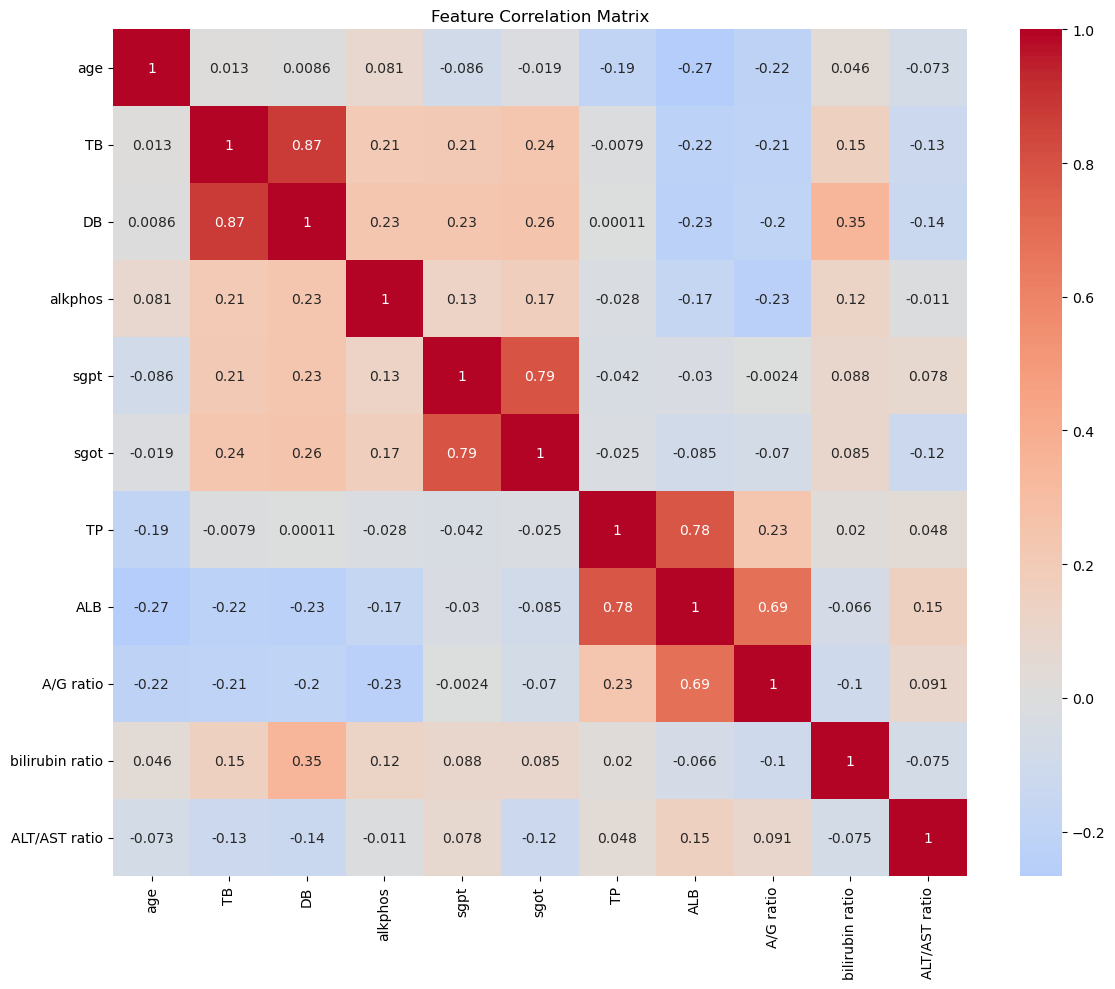

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the numeric feature columns
features_df = df_standard[scale_cols]

# Correlation Matrix to determine highly correlated features
plt.figure(figsize=(12, 10))
correlation_matrix = features_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [68]:
# Drop the highly correlated features (drop one from each pair)
cols_to_drop = ['DB', 'sgot', 'ALB', 'A/G ratio']
df_dropped = df_standard.drop(columns=cols_to_drop)
df_dropped.head()

,age,gender,TB,alkphos,sgpt,TP,target,bilirubin ratio,ALT/AST ratio
0,1.069313,1,1.223586,1.680715,-0.092140,0.937332,1.0,0.463941,-0.472172
1,1.069313,1,0.643743,0.820279,-0.114045,0.476661,1.0,0.656711,-0.093879
2,0.821911,1,-0.370981,-0.447733,-0.365961,0.292392,1.0,0.110585,-0.378517
3,1.687818,1,0.096115,-0.394213,-0.294768,0.753063,1.0,0.491758,-0.756841
4,0.079704,1,-0.242127,-0.340693,-0.338579,1.029466,1.0,0.073045,0.647230


### **Engineering Ordinal Features**

Categorize age into ordinal groups labeled with numeric values. Uses dynamic bin ranges. 
* (1) Young: Age below 30
* (2) Middle-Aged: Age between 30 and 50 (inclusive)
* (3) Senior: Age above 50

In [69]:
# Get min and max age values
age_min = df['age'].min()
age_max = df['age'].max()

# Ensure distinct bin edges by forcing strictly increasing values
age_bins = sorted(set([age_min, 30, 50, age_max]))  # Remove duplicates and sort
age_labels = ['young', 'middle-aged', 'senior']

# Ensure at least three unique bin edges
if len(age_bins) < 3:
    age_bins = [age_min, (age_min + age_max) / 2, age_max]  # Fallback bins
    age_labels = ['young', 'senior']
    print('Used fallback bins')

# Create new df
df_binned = df_dropped.copy()

# Bin age groups using pd.cut()
df_binned['age_group'] = pd.cut(df_binned['age'], age_bins, labels=age_labels, include_lowest=True)

# Map age_group to age_ordinal
age_map = {'young':1, 'middle-aged':2, 'senior':3}
df_binned['age_ordinal'] = df_binned['age_group'].map(age_map)

# Display first few rows
df_binned.head(6)

,age,gender,TB,alkphos,sgpt,TP,target,bilirubin ratio,ALT/AST ratio,age_group,age_ordinal
0,1.069313,1,1.223586,1.680715,-0.092140,0.937332,1.0,0.463941,-0.472172,NaN,NaN
1,1.069313,1,0.643743,0.820279,-0.114045,0.476661,1.0,0.656711,-0.093879,NaN,NaN
2,0.821911,1,-0.370981,-0.447733,-0.365961,0.292392,1.0,0.110585,-0.378517,NaN,NaN
3,1.687818,1,0.096115,-0.394213,-0.294768,0.753063,1.0,0.491758,-0.756841,NaN,NaN
4,0.079704,1,-0.242127,-0.340693,-0.338579,1.029466,1.0,0.073045,0.647230,NaN,NaN
5,-1.157306,0,-0.387087,-0.563007,-0.355008,0.476661,1.0,-0.490052,0.610065,NaN,NaN


In [70]:
# Check the distribution of age_group
df_binned["age_group"].value_counts()

age_group
young          0
middle-aged    0
senior         0
Name: count, dtype: int64

In [71]:
# Check the distribution of age_ordinal
df_binned["age_ordinal"].value_counts()

age_ordinal
1    0
2    0
3    0
Name: count, dtype: int64

### **Dimensionality Reduction**

Apply PCA and retain components that explain at least 95% of variance.

In [72]:
from sklearn.decomposition import PCA

# Create new df
df_PCA = df_binned.copy()

# Exclude non-numeric columns from PCA
x_pca = df_PCA.drop(columns=['gender', 'target', 'age_group', 'age_ordinal'])

# Initialize and fit pca
pca = PCA(n_components=0.95) # retain 95% of variance
x_PCA_transformed = pca.fit_transform(x_pca)

# Output the number of principal components retained
print(f'Number of principal components retained: {pca.n_components_}')

Number of principal components retained: 7


## **Logistic Regression Model**

Train a logistic regression model on the processed dataset and evaluate its performance with its accuracy score, confusion matrix and a classification report.

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Train logistic regression on PCA-adjusted data

# Define variables
X = x_PCA_transformed
y = df = df_PCA['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Initialize and fit model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Predict target feature
y_pred = logreg_model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print('\nFeatures:', x_pca.columns)
print('Feature Coefficient:', logreg_model.coef_)

Accuracy: 0.678082191780822

Confusion Matrix:
 [[ 5 41]
 [ 6 94]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.45      0.11      0.18        46
         1.0       0.70      0.94      0.80       100

    accuracy                           0.68       146
   macro avg       0.58      0.52      0.49       146
weighted avg       0.62      0.68      0.60       146


Features: Index(['age', 'TB', 'alkphos', 'sgpt', 'TP', 'bilirubin ratio',
       'ALT/AST ratio'],
      dtype='object')
Feature Coefficient: [[ 1.84354151 -0.61279744  0.51373735 -0.47613542  0.40642399  0.73784582
  -0.38390565]]


## **Visualization**
* Plot the distribution of Total Bilirubin (TB) for liver and non-liver patients.


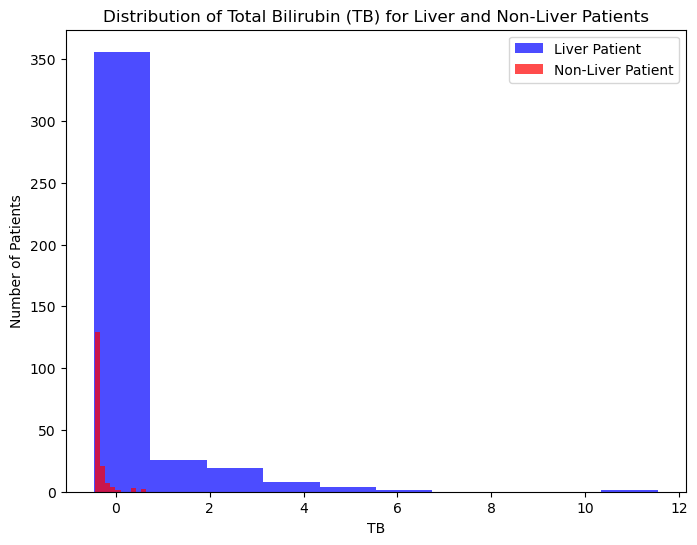

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define variables
liver = df_binned[df_binned['target'] == 1.0]['TB']
nonliver = df_binned[df_binned['target'] == 0.0]['TB']

# Plot histograms
plt.figure(figsize=(8,6))
plt.hist(liver, color='blue', alpha=0.7, label='Liver Patient');
plt.hist(nonliver, color='red', alpha=0.7, label='Non-Liver Patient');

# Annotations
plt.title('Distribution of Total Bilirubin (TB) for Liver and Non-Liver Patients')
plt.xlabel('TB')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

Text(0.5, 0, 'TB')

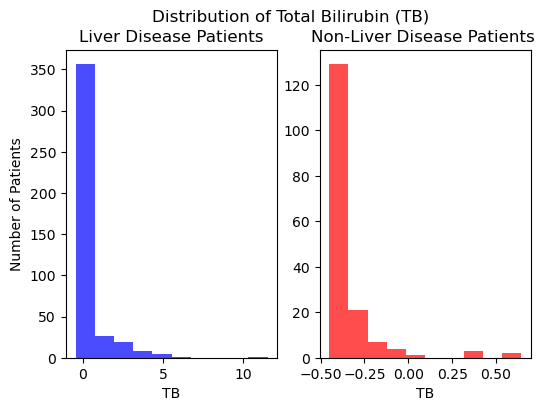

In [ ]:
# Two separate histograms
plt.figure(figsize=(6,4))
plt.suptitle('Distribution of Total Bilirubin (TB)')

plt.subplot(1, 2, 1)
plt.hist(liver, color='blue', alpha=0.7);
plt.title('Liver Disease Patients')
plt.xlabel('TB')
plt.ylabel('Number of Patients')

plt.subplot(1, 2, 2)
plt.hist(nonliver, color='red', alpha=0.7);
plt.title('Non-Liver Disease Patients ')
plt.xlabel('TB')

The distribution of Total Bilirubin appears to be proportionally similar for liver and non-liver disease patients. There are far more patients with TB closer to zero, and fewer patients with TB greater than zero. The majority of both liver and non-liver disease patients have TB around -0.50 to 0. However, many patients with liver disease also have TB greater than 0, something less common in non-liver disease patients. This pattern suggests that having a higher TB can be associated with liver disease. I would expect TB to be a moderately strong predictor because there is a clear divide between liver and non-liver disease patients when it comes to higher TB scores (greater than 0), but only to a certain extent because many liver disease patients have TB close to 0, similar to non-liver disease patients. I should note that due to the class imbalance, there are far more data points for the liver disease patients.

### **Final Thoughts**

The model returned 10 true positives, 23 false positives, 104 true negatives, and 9 false negatives. 

In the context of medical diagnosing, we want to optimize the model by minimizing the number of false negatives -- it is more important that the model accurately identifies all cases of liver disease, as we don't want patients who have liver disease to be told they do *not* have liver disease. A result of 9 false negatives compared to 10 true positives is not ideal at all -- the model missed about half of all positive liver disease cases. There are many false positivies, and while not ideal, there are fewer immediate risks to a patient's health when identified as  a false positive. 

The classification report reveals that the model has a severe class imbalance, with  0.55 precision, 0.29 recall, and 0.38 f1-score for the non-liver disease patients (class 0.0). This means that the model is highly biased towards the liver class (1.0) and it poorly classifies non-liver patients when it is presented with the data. The model's poor performance can likely be attributed to the class imbalance; in future model development, balancing classes will be key. Although the overall accuracy of the model is 0.73, this metric disguises the model's bias -- the high number of false negatives and the class imbalance for non-liver patients.

The three features that seem to have the strongest impact on the predictions are Bilirubin Ratio (0.74), Total Bilirubin (TB = -0.61), and Alanine  Aminotransferase (sgpt = 0.51). These findings are consistent with current medical knowledge about liver disease, as all three are some of the most significant known predictors of liver disease.

Sources:
* https://link.springer.com/article/10.1007/s42044-023-00138-9
* https://pmc.ncbi.nlm.nih.gov/articles/PMC8283287/